# Upscale GEDI biomass with PALSAR-2 backscatter

This practical will take the GEDI data we used in the last notebook, overlay it with PALSAR data and look for a relationship between the two. First we will load GEDI data into RAM using the same method as the last notebook.

The code for these tasks is held within the ***gediL4Areader.py*** file in the same directory as this notebook.

In [1]:
# import libraries
import numpy as np
from sys import path
path.append("/geos/netdata/active_sensing/code_active/10_upscaling")
from gediL4Areader import gediL4A,dataTable

# define a filename
gediName='/Users/dougal/data/teaching/active_sensing/10_fusion/gedi/L4A/subset.GEDI04_A_2020178113837_O08714_02_T00308_02_002_02_V002.h5'

# read the data
gedi=gediL4A(gediName)

# filter out poor quality data
gedi.filterQuality()

Found 97329 footprints
Filtered 68206 from 97329


Now load the PALSAR data and check that it looks sensible. The files are large and this may take a minute.

*Do these figures match those you have in QGIS?*

In [2]:
# import libraries
import rasterio
import matplotlib.pyplot as plt

# open the two files
palsarHHname='/Users/dougal/data/teaching/active_sensing/10_fusion/palsar/merged_HH.tif'
palsarHVname='/Users/dougal/data/teaching/active_sensing/10_fusion/palsar/merged_HV.tif'
palsarHH=rasterio.open(palsarHHname)
palsarHV=rasterio.open(palsarHVname)

# read the raster layers
hh=palsarHH.read(1)
hv=palsarHV.read(1)

# plot to the screen for sanity check
#plt.imshow(hh)
#plt.title('HH')
#plt.show()

#plt.imshow(hv)
#plt.title('HV')
#plt.show()


## Determining the relationship

We have points of AGBD estimates from GEDI and a raster of backscatter from PALSAR-2. Is there a useful relationship between one and the other? To test this we need to make a table of GEDI AGBD values and backscatter from the corresponding PALSAR-2 pixels.

Run the code below to make a plot and determine the linear correlation.

*Which layer has the higher correlation? Why do you think that is, based on your understanding of radars?*

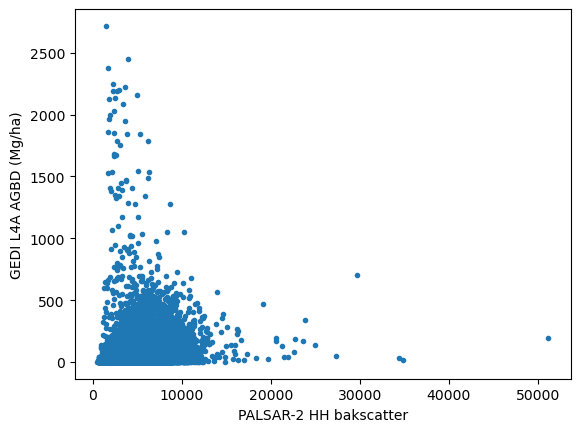

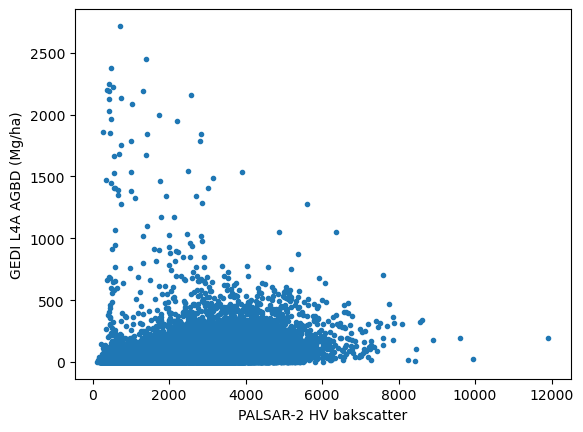

Correlation between AGBD and HH is 0.278
Correlation between AGBD and HV is 0.327


In [3]:
# make a table from the two datasets
mergedData=dataTable(gedi,palsarHH,hh,palsarHV,hv)

# plot that table up
mergedData.plotHH()
mergedData.plotHV()

# determine linear correlation
mergedData.correlHH()
mergedData.correlHV()

## Machine learning

The relationship is not entirely clear. Machine learning is a useful for finding the best relationship between a variable of interest and multiple variables of interest. Here we will use it to predict AGBD from a combination of PALSAR-2 HH and HV backscatter.

We will use the random forest algoithm as implemented in the sklearn python package. The code below will split the data into a training and a validate set, then train a model to predict GEDI's AGBD from PALSAR with the table of data we have extracted and then predict biomass across all of the PALSAR data.

*Does the scatterplot look accurate?*

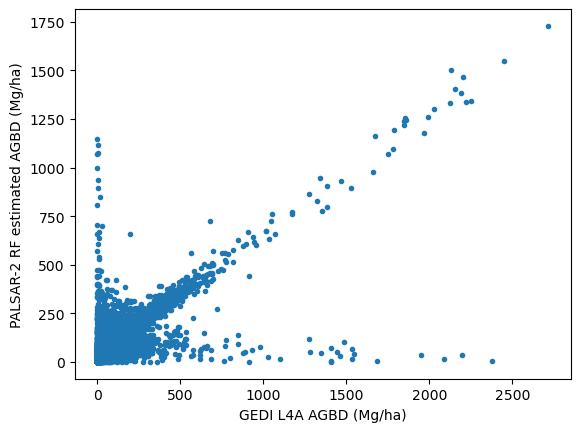

In [4]:
# parameters for our RF
n_estimators=200
max_depth=None

# split into 70% training, 30% validation
mergedData.splitData(trainFrac=0.7)

# calibrate the model
mergedData.buildRF(n_estimators,max_depth)
    
# predict the model
mergedData.predict()

# make a scatterpot of all predicted versus GEDI AGBD
mergedData.scatterAll()

## Validation

Our scatterpot gives us an idea, but we must validate our model with data indepdent from that used to train. The command below will use the 30% of the data we have reserved to calculate some standard error metrics.

*Is this a useful model? What could be done to improve it?*

In [5]:
# validate
mergedData.validateRF()

Bias 3.8 Mg/ha
RMSE 118.59 Mg/ha
Correlation 0.18
For a mean AGBD of 54.9 Mg/ha


## Spatial validation

The above randomly selected footprints from within the GEDI flightline. This means that the calibration and validation data overlap in space and time. It is a more stringent test of a model to validate the data at a different space and time to where it was calibrated. That can be done by splitting the training and validation data spatially. The code below splits the data by latitude.

*What does this do to the accuracy results?*

In [6]:
# parameters for our RF
n_estimators=200
max_depth=None

# split into 70% training, 30% validation
mergedData.splitSpatially(trainFrac=0.7)

# calibrate the model
mergedData.buildRF(n_estimators,max_depth)

# validate
mergedData.validateRF()

Bias 9.086 Mg/ha
RMSE 81.27 Mg/ha
Correlation 0.299
For a mean AGBD of 47.74 Mg/ha


## Multiple GEDI files

Up until now we have read a single GEDI